In [174]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from pmdarima import auto_arima

## Data Preprocessing

In [175]:
# Load data sets.

itemDf = pd.read_csv("../Data/item.csv")
promotionDf = pd.read_csv("../Data/promotion.csv")
salesDf = pd.read_csv("../Data/sales.csv")
supermarketsDf = pd.read_csv("../Data/supermarkets.csv")

In [176]:
salesDf

,code,amount,units,time,province,week,customerId,supermarket,basket,day,voucher
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0
3,9999985067,0.85,1,1148,2,1,162016,244,3,1,0
4,9999985131,2.19,1,1323,2,1,89437,244,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1048099,1510000011,2.35,1,1307,2,27,43825,346,665448,189,0
1048100,3620000489,0.99,1,1307,2,27,43825,346,665448,189,0
1048101,9999971309,2.00,2,1410,2,27,42140,346,665449,189,0
1048102,3620000250,1.98,2,1415,2,27,53544,346,665450,189,0


##### Visualization of daily sales

In [177]:
# Aggregate sales data to find daily sales.

daily_sales = salesDf.groupby('day')['amount'].sum().reset_index()
daily_sales_by_province = salesDf.groupby(['day', 'province'])['amount'].sum().reset_index()

In [178]:
daily_sales

,day,amount
0,1,20740.410
1,2,11754.540
2,3,10400.260
3,4,10602.675
4,5,9337.290
...,...,...
161,191,7159.270
162,192,5463.000
163,193,5788.450
164,194,4852.430


In [179]:
daily_sales_by_province

,day,province,amount
0,1,1,7244.79
1,1,2,13495.62
2,2,1,6344.45
3,2,2,5410.09
4,3,1,5499.18
...,...,...,...
297,191,1,7159.27
298,192,1,5463.00
299,193,1,5788.45
300,194,1,4852.43


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


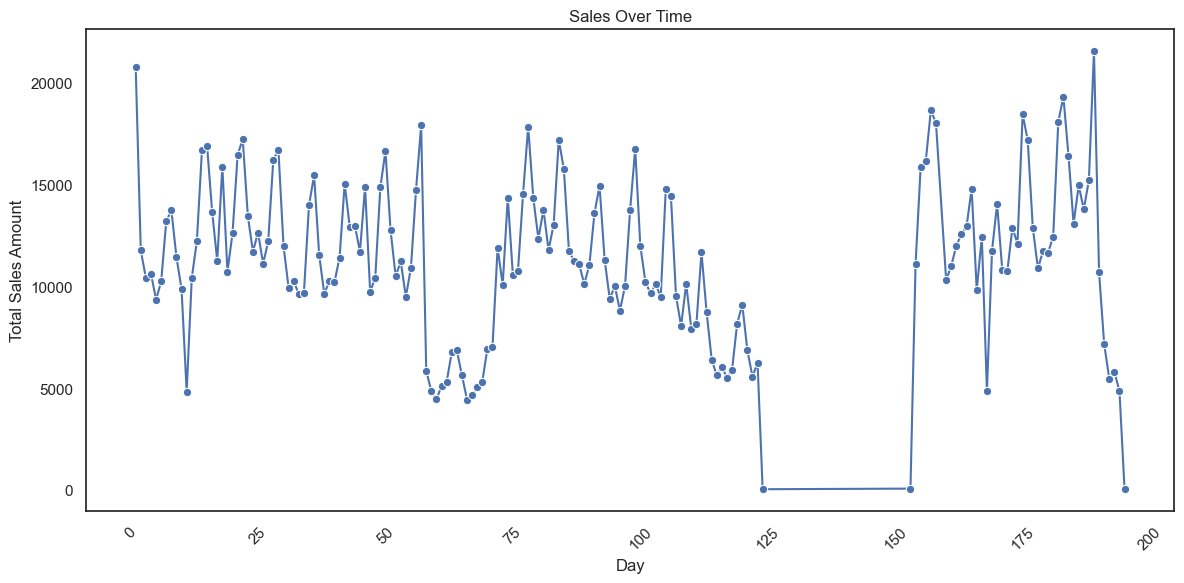

In [180]:
# Daily sales over time.

plt.figure(figsize=(12, 6))

sns.lineplot(data=daily_sales, x='day', y='amount', marker='o')

plt.title('Sales Over Time')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [181]:
daily_sales

,day,amount
0,1,20740.410
1,2,11754.540
2,3,10400.260
3,4,10602.675
4,5,9337.290
...,...,...
161,191,7159.270
162,192,5463.000
163,193,5788.450
164,194,4852.430


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


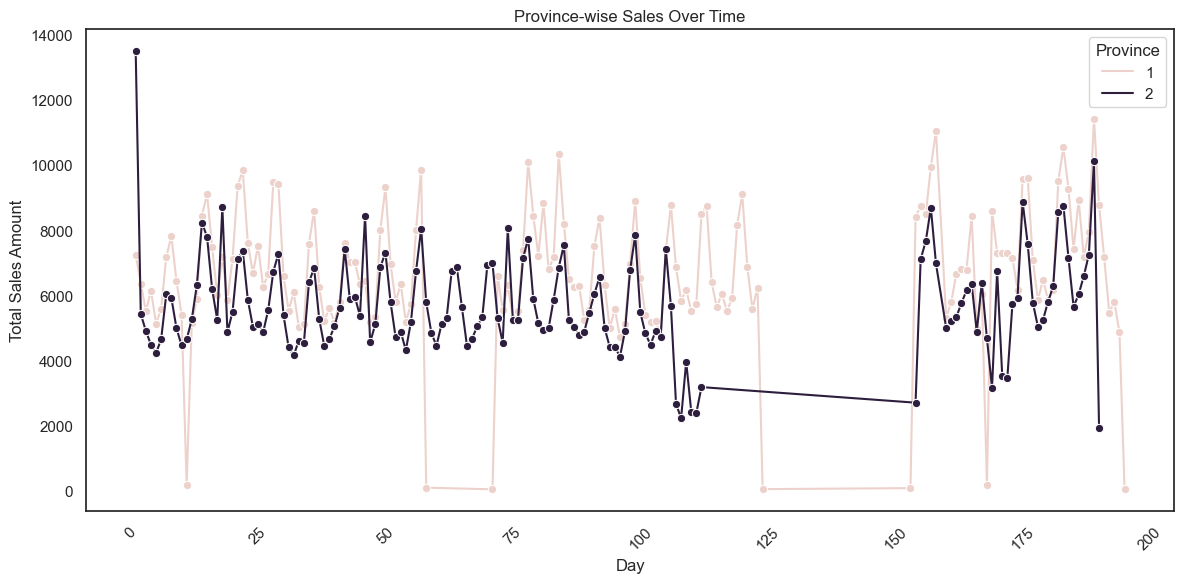

In [182]:
# Daily sales over time Province wise.

plt.figure(figsize=(12, 6))

sns.lineplot(data=daily_sales_by_province, x='day', y='amount', hue='province', marker='o')

plt.title('Province-wise Sales Over Time')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.legend(title='Province')
plt.tight_layout()
plt.show()
    

In [183]:
sales_province_1 = daily_sales_by_province[daily_sales_by_province['province'] == 1].reset_index(drop=True)
sales_province_2 = daily_sales_by_province[daily_sales_by_province['province'] == 2].reset_index(drop=True)

sales_province_1["Original_amount"] = sales_province_1["amount"]
sales_province_2["Original_amount"] = sales_province_2["amount"]

In [184]:
all_days = pd.DataFrame({'day': range(1, 196)})

sales_province_1 = all_days.merge(sales_province_1, on='day', how='left')
sales_province_2 = all_days.merge(sales_province_2, on='day', how='left')

##### Impute Missing values and Handle outliers for Province 1

In [185]:
p1_temp = sales_province_1.copy()
p1_temp.set_index('day', inplace=True)
p1_temp["imputed_amount"] = p1_temp["amount"]


In [186]:
p1_temp[p1_temp["amount"].isna()]

# Day 59-70, 125-152, 159 are missing

,province,amount,Original_amount,imputed_amount
day,,,,
59,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN


In [187]:
# Use ARIMA model to impute missing values.

model1 = auto_arima(p1_temp[:58]['amount'], seasonal=True, m=12, trace=True, 
                    error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1040.264, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1038.913, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1037.416, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1032.913, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1190.358, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1034.956, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1035.330, Time=0.07 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1034.995, Time=0.16 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1036.953, Time=0.04 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1037.327, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1034.168, Time=0.05 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1035.527, Time=0.04 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=1034.285, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1034.678, Time=0.07 sec
 ARIMA(1,0,2)(0,0,1

In [188]:
p1_temp["imputed_amount"][58:70] =  model1.predict(n_periods=12, return_conf_int=True)[0]

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [189]:
# # Use ARIMA model to impute missing values.

model2 = auto_arima(p1_temp[:124]['imputed_amount'], seasonal=True, m=28, trace=True, 
                    error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[28] intercept   : AIC=2201.615, Time=1.34 sec
 ARIMA(0,0,0)(0,0,0)[28] intercept   : AIC=2212.893, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[28] intercept   : AIC=2202.809, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[28] intercept   : AIC=2201.672, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[28]             : AIC=2540.328, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[28] intercept   : AIC=2207.222, Time=0.54 sec
 ARIMA(2,0,2)(1,0,0)[28] intercept   : AIC=2204.399, Time=1.25 sec
 ARIMA(2,0,2)(2,0,1)[28] intercept   : AIC=inf, Time=43.33 sec
 ARIMA(2,0,2)(1,0,2)[28] intercept   : AIC=2201.030, Time=42.82 sec
 ARIMA(2,0,2)(0,0,2)[28] intercept   : AIC=2201.718, Time=35.36 sec
 ARIMA(2,0,2)(2,0,2)[28] intercept   : AIC=inf, Time=45.64 sec
 ARIMA(1,0,2)(1,0,2)[28] intercept   : AIC=inf, Time=34.20 sec
 ARIMA(2,0,1)(1,0,2)[28] intercept   : AIC=2203.528, Time=35.55 sec
 ARIMA(3,0,2)(1,0,2)[28] intercept   : AIC=2202.659, Time=44.75 sec
 ARIMA(2,0,3)(1,0,2)[28] in

In [190]:
p1_temp["imputed_amount"][124:152] =  model2.predict(n_periods=28, return_conf_int=True)[0]

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [191]:
p1_temp = p1_temp.reset_index()

In [192]:
sales_province_1["amount"] = p1_temp["imputed_amount"]

In [193]:
sales_province_1[sales_province_1["amount"].isna()]

,day,province,amount,Original_amount
158,159,NaN,NaN,NaN


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


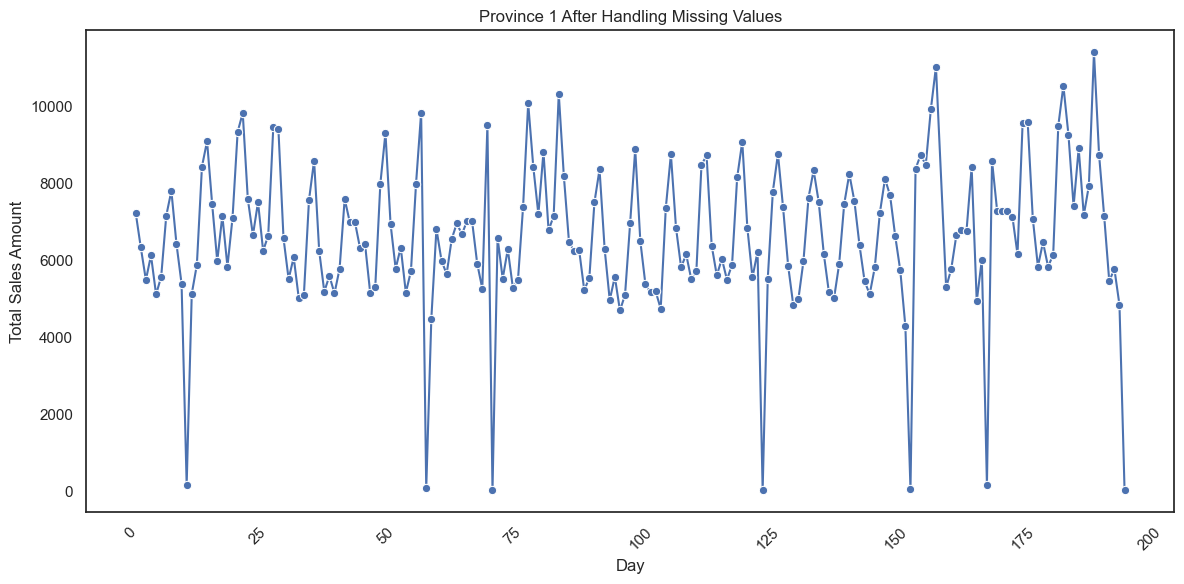

In [194]:
# Daily sales after handle missing values.

plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_province_1, x='day', y='amount', marker='o')

plt.title('Province 1 After Handling Missing Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

##### Identify outliers for Province 1

In [195]:
# Use Iforest for identify outlers.

sales_province_1['amount_filled'] = sales_province_1['amount'].fillna(0)

iso_forest = IsolationForest(contamination=0.1, random_state=42)
sales_province_1['outlier'] = iso_forest.fit_predict(sales_province_1[['amount_filled']])

sales_province_1.loc[sales_province_1['outlier'] == -1, 'amount_filled'] = np.nan 
sales_province_1.loc[sales_province_1['amount'] == 0, 'amount_filled'] = np.nan

#Outliers represented as -1 and amount as nan.

In [196]:
temp_p1 = sales_province_1.copy()

start_date = '2023-01-01'

temp_p1['date'] = pd.to_datetime(start_date) + pd.to_timedelta(temp_p1['day'] - 1, unit='D')

temp_p1 = temp_p1.set_index('date')

In [197]:
temp_p1

,day,province,amount,Original_amount,amount_filled,outlier
date,,,,,,
2023-01-01,1,1.0,7244.79,7244.79,7244.79,1
2023-01-02,2,1.0,6344.45,6344.45,6344.45,1
2023-01-03,3,1.0,5499.18,5499.18,5499.18,1
2023-01-04,4,1.0,6136.43,6136.43,6136.43,1
2023-01-05,5,1.0,5123.32,5123.32,5123.32,1
...,...,...,...,...,...,...
2023-07-10,191,1.0,7159.27,7159.27,7159.27,1
2023-07-11,192,1.0,5463.00,5463.00,5463.00,1
2023-07-12,193,1.0,5788.45,5788.45,5788.45,1


In [198]:
temp_p1['amount_imputed'] = temp_p1['amount_filled'].interpolate(method='time')

In [199]:
temp_p1 = temp_p1.reset_index()

In [200]:
sales_province_1["amount"] =  temp_p1["amount_imputed"]

In [201]:
sales_province_1["Original_amount"].fillna(0)

0      7244.79
1      6344.45
2      5499.18
3      6136.43
4      5123.32
        ...   
190    7159.27
191    5463.00
192    5788.45
193    4852.43
194      29.36
Name: Original_amount, Length: 195, dtype: float64

In [202]:
sales_province_1

,day,province,amount,Original_amount,amount_filled,outlier
0,1,1.0,7244.79,7244.79,7244.79,1
1,2,1.0,6344.45,6344.45,6344.45,1
2,3,1.0,5499.18,5499.18,5499.18,1
3,4,1.0,6136.43,6136.43,6136.43,1
4,5,1.0,5123.32,5123.32,5123.32,1
...,...,...,...,...,...,...
190,191,1.0,7159.27,7159.27,7159.27,1
191,192,1.0,5463.00,5463.00,5463.00,1
192,193,1.0,5788.45,5788.45,5788.45,1
193,194,1.0,4852.43,4852.43,4852.43,1


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

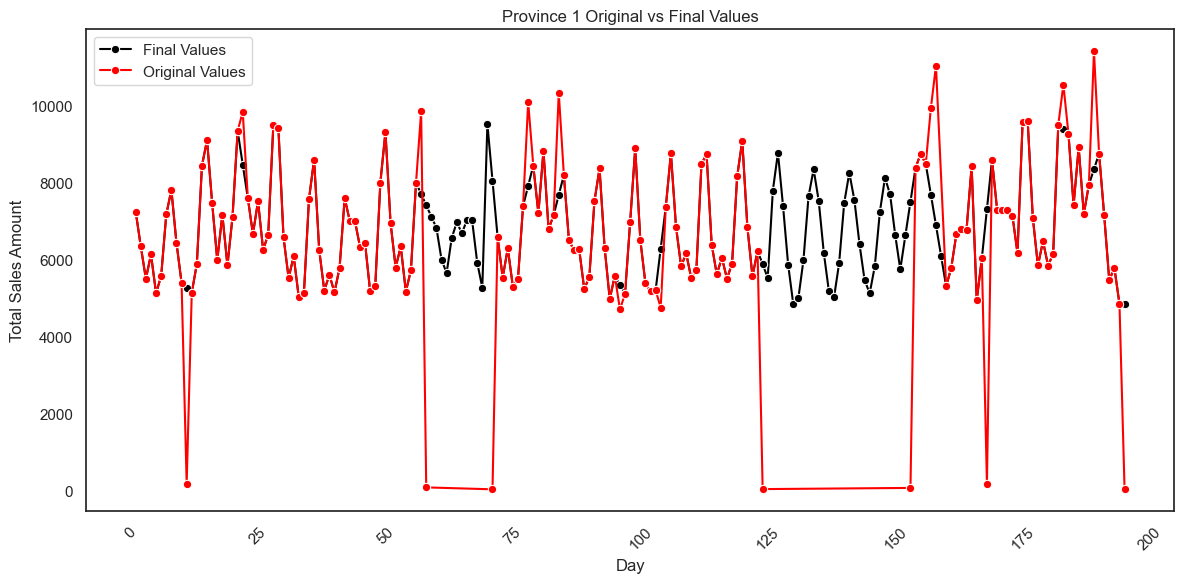

In [203]:
# Plot of Original daily sales and missing value and outlier handle sales data.

plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_province_1, x='day', y='amount', marker='o', label='Final Values', color='black')

sns.lineplot(data=sales_province_1, x='day', y='Original_amount', marker='o', label='Original Values', color='red')

plt.title('Province 1 Original vs Final Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

#### Impute Missing values and Handling outliers for Province 2

In [204]:
p2_temp = sales_province_2.copy()
p2_temp.set_index('day', inplace=True)
p2_temp["imputed_amount"] = p2_temp["amount"]

In [205]:
p2_temp[p2_temp["amount"].isna()]

# Day 113-153, 191-195 are missing

,province,amount,Original_amount,imputed_amount
day,,,,
113,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN
119,NaN,NaN,NaN,NaN
120,NaN,NaN,NaN,NaN
121,NaN,NaN,NaN,NaN


In [206]:
p2_temp.loc[159, "imputed_amount"] = 0

In [207]:
# Use ARIMA model to impute missing values.

model1 = auto_arima(p2_temp[:112]['amount'], seasonal=True, m=41, trace=True, 
                    error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[41] intercept   : AIC=inf, Time=28.50 sec
 ARIMA(0,1,0)(0,0,0)[41] intercept   : AIC=1947.919, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[41] intercept   : AIC=1934.980, Time=7.85 sec
 ARIMA(0,1,1)(0,0,1)[41] intercept   : AIC=1909.261, Time=8.07 sec
 ARIMA(0,1,0)(0,0,0)[41]             : AIC=1946.330, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[41] intercept   : AIC=1911.658, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[41] intercept   : AIC=1911.319, Time=10.24 sec
 ARIMA(0,1,1)(0,0,2)[41] intercept   : AIC=1911.226, Time=20.60 sec
 ARIMA(0,1,1)(1,0,0)[41] intercept   : AIC=1909.580, Time=10.61 sec
 ARIMA(0,1,1)(1,0,2)[41] intercept   : AIC=1913.222, Time=37.21 sec
 ARIMA(0,1,0)(0,0,1)[41] intercept   : AIC=1944.864, Time=5.74 sec
 ARIMA(1,1,1)(0,0,1)[41] intercept   : AIC=inf, Time=15.97 sec
 ARIMA(0,1,2)(0,0,1)[41] intercept   : AIC=inf, Time=18.51 sec
 ARIMA(1,1,0)(0,0,1)[41] intercept   : AIC=1935.536, Time=2.48 sec
 ARIMA(1,1,2)(0,0,1)[41] in

In [208]:
p2_temp["imputed_amount"][112:153] =  model1.predict(n_periods=41, return_conf_int=True)[0]

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [209]:
model2 = auto_arima(p2_temp[:190]['imputed_amount'], seasonal=True, m=5, trace=True, 
                    error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=3337.120, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=3321.401, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=3276.735, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=3335.388, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=3275.320, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=3276.867, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=3265.452, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=3268.399, Time=0.19 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=3267.374, Time=0.26 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=3269.349, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=3320.201, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=3264.678, Time=0.18 sec
 ARIMA(2,1,1)(1,0,0)[5] intercept   : AIC=3

In [210]:
p2_temp["imputed_amount"][190:]=  model2.predict(n_periods=5, return_conf_int=True)[0]

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [211]:
p2_temp

,province,amount,Original_amount,imputed_amount
day,,,,
1,2.0,13495.620,13495.620,13495.620000
2,2.0,5410.090,5410.090,5410.090000
3,2.0,4901.080,4901.080,4901.080000
4,2.0,4466.245,4466.245,4466.245000
5,2.0,4213.970,4213.970,4213.970000
...,...,...,...,...
191,NaN,NaN,NaN,5318.422580
192,NaN,NaN,NaN,6011.089746
193,NaN,NaN,NaN,6103.243756


In [212]:
p2_temp = p2_temp.reset_index()
sales_province_2["amount"] = p2_temp["imputed_amount"]
sales_province_2[sales_province_2["amount"].isna()]

,day,province,amount,Original_amount


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


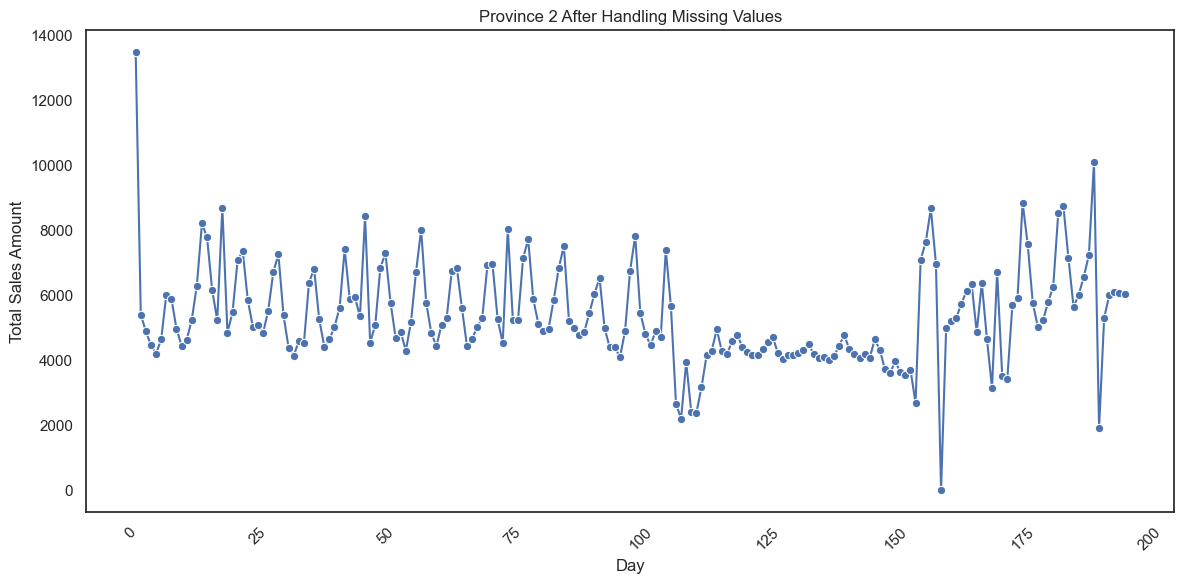

In [213]:
# Daily sales after handle missing values.

plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_province_2, x='day', y='amount', marker='o')

plt.title('Province 2 After Handling Missing Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

##### Identify outliers for Province 2

In [214]:
# Use Iforest for identify outliers.

sales_province_2['amount_filled'] = sales_province_2['amount'].fillna(0)

iso_forest = IsolationForest(contamination=0.1, random_state=42)
sales_province_2['outlier'] = iso_forest.fit_predict(sales_province_2[['amount_filled']])

sales_province_2.loc[sales_province_2['outlier'] == -1, 'amount_filled'] = np.nan 
sales_province_2.loc[sales_province_2['amount'] == 0, 'amount_filled'] = np.nan

#Outliers represented as -1 and amount as nan.

In [215]:
temp_p2 = sales_province_2.copy()

start_date = '2023-01-01'

temp_p2['date'] = pd.to_datetime(start_date) + pd.to_timedelta(temp_p2['day'] - 1, unit='D')

temp_p2 = temp_p2.set_index('date')

In [216]:
temp_p2['amount_imputed'] = temp_p2['amount_filled'].interpolate(method='time')
temp_p2 = temp_p2.reset_index()
sales_province_2["amount"] =  temp_p2["amount_imputed"]
sales_province_2["Original_amount"].fillna(0)

0      13495.620
1       5410.090
2       4901.080
3       4466.245
4       4213.970
         ...    
190        0.000
191        0.000
192        0.000
193        0.000
194        0.000
Name: Original_amount, Length: 195, dtype: float64

In [217]:
sales_province_2.loc[0,"amount"] = 13495.62

c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

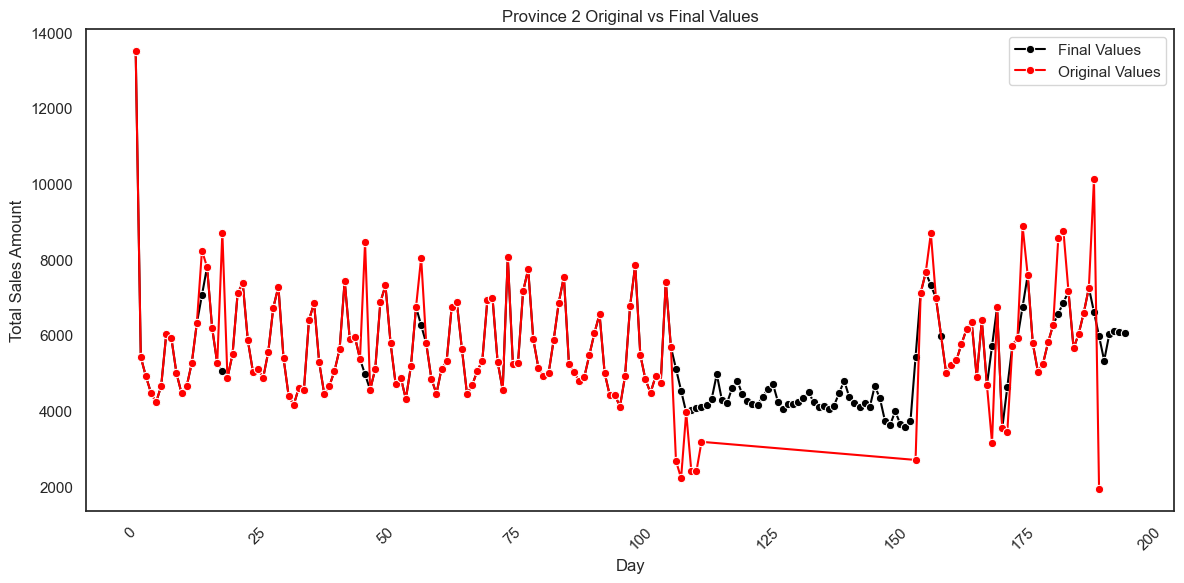

In [218]:
# Plot of Original daily sales and missing value and outlier handle sales data.

plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_province_2, x='day', y='amount', marker='o', label='Final Values', color='black')

sns.lineplot(data=sales_province_2, x='day', y='Original_amount', marker='o', label='Original Values', color='red')

plt.title('Province 2 Original vs Final Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [219]:
sales_province_2

,day,province,amount,Original_amount,amount_filled,outlier
0,1,2.0,13495.620000,13495.620,NaN,-1
1,2,2.0,5410.090000,5410.090,5410.090000,1
2,3,2.0,4901.080000,4901.080,4901.080000,1
3,4,2.0,4466.245000,4466.245,4466.245000,1
4,5,2.0,4213.970000,4213.970,4213.970000,1
...,...,...,...,...,...,...
190,191,NaN,5318.422580,NaN,5318.422580,1
191,192,NaN,6011.089746,NaN,6011.089746,1
192,193,NaN,6103.243756,NaN,6103.243756,1
193,194,NaN,6073.319991,NaN,6073.319991,1


##### Final Data Set for Total daily sales after missing value and outlier handle.

In [220]:
final_sales = sales_province_1
final_sales["amount"] = sales_province_1["amount"]+sales_province_2["amount"]

In [221]:
final_sales = final_sales.drop(["province","Original_amount", "amount_filled", "outlier"], axis=1)

In [222]:
final_sales['amount'] = final_sales['amount'].round(2)

In [223]:
final_sales

,day,amount
0,1,20740.41
1,2,11754.54
2,3,10400.26
3,4,10602.68
4,5,9337.29
...,...,...
190,191,12477.69
191,192,11474.09
192,193,11891.69
193,194,10925.75


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

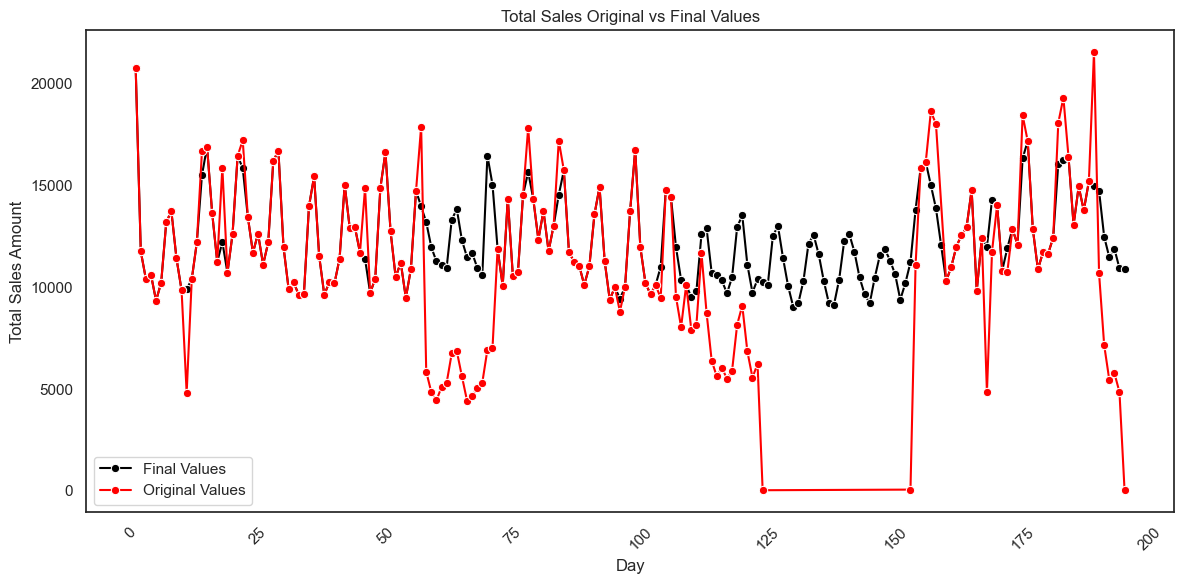

In [224]:
# Plot of Original daily sales and missing value and outlier handle sales data.

plt.figure(figsize=(12, 6))

sns.lineplot(data=final_sales, x='day', y='amount', marker='o', label='Final Values', color='black')

sns.lineplot(data=daily_sales, x='day', y='amount', marker='o', label='Original Values', color='red')

plt.title('Total Sales Original vs Final Values')
plt.xlabel('Day')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Forecasting Model for next Month (30 days)

In [225]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

In [226]:
data = final_sales.copy()

start_date = '2024-01-01'

data['day'] = pd.to_datetime(start_date) + pd.to_timedelta(data['day'] - 1, unit='D')

data.set_index('day', inplace=True)
data = data.sort_index()

In [227]:
# Create lagged features.

def create_lagged_features(df, lag=30):
    df_lagged = df.copy()
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = df_lagged['amount'].shift(i)
    df_lagged.dropna(inplace=True)
    return df_lagged

lagged_data = create_lagged_features(data, lag=30)

In [228]:
lagged_data

,amount,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
day,,,,,,,,,,,,,,,,,,,,,
2024-01-31,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,12626.46,11689.13,13451.70,15840.32,...,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29,10602.68,10400.26,11754.54,20740.41
2024-02-01,10228.96,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,12626.46,11689.13,13451.70,...,9905.94,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29,10602.68,10400.26,11754.54
2024-02-02,9617.80,10228.96,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,12626.46,11689.13,...,10389.79,9905.94,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29,10602.68,10400.26
2024-02-03,9652.40,9617.80,10228.96,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,12626.46,...,12201.49,10389.79,9905.94,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29,10602.68
2024-02-04,13974.94,9652.40,9617.80,10228.96,9917.10,11969.29,16686.28,16208.08,12193.12,11108.96,...,15495.62,12201.49,10389.79,9905.94,9850.52,11417.58,13724.40,13197.57,10228.29,9337.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-09,12477.69,14716.94,14953.06,15189.18,13766.60,14942.87,13054.60,16408.76,16236.78,16064.80,...,14030.06,14296.46,11981.02,12411.89,9816.39,14774.71,12928.60,12553.74,11983.02,10997.57
2024-07-10,11474.09,12477.69,14716.94,14953.06,15189.18,13766.60,14942.87,13054.60,16408.76,16236.78,...,10815.32,14030.06,14296.46,11981.02,12411.89,9816.39,14774.71,12928.60,12553.74,11983.02
2024-07-11,11891.69,11474.09,12477.69,14716.94,14953.06,15189.18,13766.60,14942.87,13054.60,16408.76,...,11913.06,10815.32,14030.06,14296.46,11981.02,12411.89,9816.39,14774.71,12928.60,12553.74


In [229]:
# Take last 30 days as test set.

train_data = lagged_data[:135]
test_data = lagged_data[135:]

In [230]:
X_train = train_data.drop(columns=['amount'])
y_train = train_data['amount']
X_test = test_data.drop(columns=['amount'])
y_test = test_data['amount']

### Random Forest Model

In [114]:
# Use Optuna to hyperparameter tuning.

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    
    y_pred = rf_model.predict(X_test)
    
    
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [120]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)


[I 2024-10-13 19:19:08,560] A new study created in memory with name: no-name-7de99977-83e3-4fff-8e3e-6ab014c83bf2
[I 2024-10-13 19:19:08,903] Trial 0 finished with value: 1671.3932675250085 and parameters: {'n_estimators': 291, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 1671.3932675250085.
[I 2024-10-13 19:19:09,056] Trial 1 finished with value: 1672.8612216423414 and parameters: {'n_estimators': 138, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 0 with value: 1671.3932675250085.
[I 2024-10-13 19:19:09,145] Trial 2 finished with value: 1671.4924109137942 and parameters: {'n_estimators': 75, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: 1671.3932675250085.
[I 2024-10-13 19:19:09,243] Trial 3 finished with value: 1707.0799672044373 and parameters: {'n_estimators': 95, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 14}. Best is trial 0 with val

In [121]:
# Best Model.

print('Best trial:')
print(study.best_trial)
print(f'Best hyperparameters: {study.best_params}')

Best trial:
FrozenTrial(number=331, state=1, values=[1507.614446136271], datetime_start=datetime.datetime(2024, 10, 13, 19, 20, 5, 867234), datetime_complete=datetime.datetime(2024, 10, 13, 19, 20, 5, 999264), params={'n_estimators': 55, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=50, log=False, low=5, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1)}, trial_id=331, value=None)
Best hyperparameters: {'n_estimators': 55, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 3}


In [122]:
best_params = study.best_params
rf_model_optimized = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
rf_model_optimized.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=55, random_state=42)

In [123]:
# Evaluation of the model.

y_pred = rf_model_optimized.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Optimized Mean Absolute Error: {mae}')

Optimized Mean Absolute Error: 1507.614446136271


In [126]:
# Prediction for next 30 days.

last_values = train_data.iloc[-1, 1:].values.reshape(1, -1)
future_predictions = []
for _ in range(30):
    next_pred = rf_model_optimized.predict(last_values)
    future_predictions.append(next_pred[0])
    last_values = np.roll(last_values, -1)
    last_values[0, -1] = next_pred[0]

future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'day': future_dates, 'amount': future_predictions})
future_df.set_index('day', inplace=True)

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with f

In [127]:
future_df

,amount
day,
2024-07-14,13369.139076
2024-07-15,13229.254366
2024-07-16,12171.691346
2024-07-17,12579.707015
2024-07-18,11882.220925
2024-07-19,11021.819578
2024-07-20,12279.359253
2024-07-21,12700.324302
2024-07-22,12649.658095


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


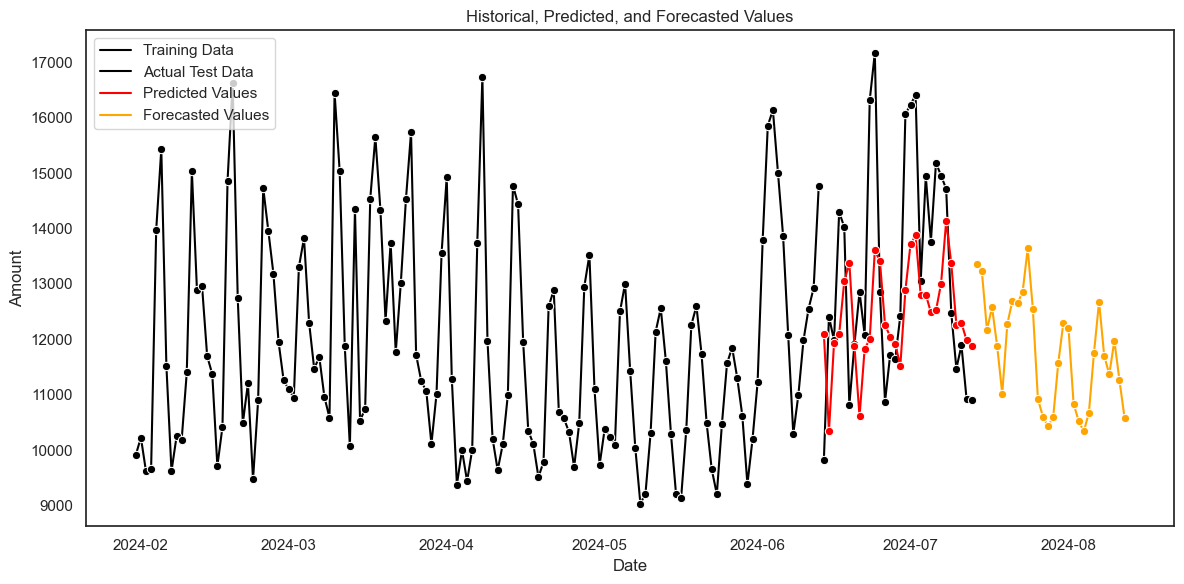

In [136]:
# Plot of Historic data, Predicted value, and forecast values.

sns.set_style('white')

plot_df = pd.DataFrame({
    'Date': np.concatenate([train_data.index, test_data.index]),
    'Amount': np.concatenate([y_train, y_test]),
    'Type': ['Training Data'] * len(y_train) + ['Actual Test Data'] * len(y_test)
})

pred_df = pd.DataFrame({
    'Date': test_data.index,
    'Amount': y_pred,
    'Type': ['Predicted Values'] * len(y_pred)
})

forecast_df = pd.DataFrame({
    'Date': future_df.index,
    'Amount': future_df['amount'],
    'Type': ['Forecasted Values'] * len(future_df)
})

combined_df = pd.concat([plot_df, pred_df, forecast_df])

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='Date', y='Amount', hue='Type', palette=['black', 'black', 'red', 'orange'], marker='o')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Historical, Predicted, and Forecasted Values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### XGB Model

In [231]:
import xgboost as xgb

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    
    xgb_model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    
    
    y_pred = xgb_model.predict(X_test)
    
    
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [232]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2024-10-13 22:26:04,001] A new study created in memory with name: no-name-4ea5f2be-5cc4-430a-a358-70f39938275a
[I 2024-10-13 22:26:04,332] Trial 0 finished with value: 1684.6824388020832 and parameters: {'n_estimators': 181, 'max_depth': 9, 'learning_rate': 0.2552599865898136, 'min_child_weight': 8, 'subsample': 0.6180273106918261, 'colsample_bytree': 0.8718136073857652}. Best is trial 0 with value: 1684.6824388020832.
[I 2024-10-13 22:26:04,783] Trial 1 finished with value: 1668.148180989583 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.12419811949456565, 'min_child_weight': 8, 'subsample': 0.622061723957299, 'colsample_bytree': 0.9024033198278865}. Best is trial 1 with value: 1668.148180989583.
[I 2024-10-13 22:26:05,019] Trial 2 finished with value: 1655.1750820312498 and parameters: {'n_estimators': 206, 'max_depth': 3, 'learning_rate': 0.14978258334354932, 'min_child_weight': 7, 'subsample': 0.5061138553901496, 'colsample_bytree': 0.7146455418675766}.

In [233]:
# Best xgb model.

print('Best trial:')
print(study.best_trial)
print(f'Best hyperparameters: {study.best_params}')

Best trial:
FrozenTrial(number=620, state=1, values=[1234.8001653645833], datetime_start=datetime.datetime(2024, 10, 13, 22, 33, 28, 460645), datetime_complete=datetime.datetime(2024, 10, 13, 22, 33, 29, 538168), params={'n_estimators': 197, 'max_depth': 10, 'learning_rate': 0.2779483930130094, 'min_child_weight': 2, 'subsample': 0.5002736380347177, 'colsample_bytree': 0.7483171904731621}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=620, value=None)
Best hyperparameters: {'n_estimators': 197, 'max_depth': 10, 'learning_

In [234]:
best_params = study.best_params
xgb_model_optimized = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)
xgb_model_optimized.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7483171904731621, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2779483930130094, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=197, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [235]:
# Evaluate the optimized xgb model.

y_pred = xgb_model_optimized.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Optimized Mean Absolute Error: {mae}')

Optimized Mean Absolute Error: 1234.8001653645833


In [241]:
# Prediction for next 30 days.

last_values = train_data.iloc[-1, 1:].values.reshape(1, -1)
future_predictions = []
for _ in range(30):
    next_pred = xgb_model_optimized.predict(last_values)
    future_predictions.append(next_pred[0])
    last_values = np.roll(last_values, -1)
    last_values[0, -1] = next_pred[0]

future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'day': future_dates, 'amount': future_predictions})
future_df.set_index('day', inplace=True)

In [242]:
future_df

,amount
day,
2024-07-14,14775.875000
2024-07-15,12701.100586
2024-07-16,12326.475586
2024-07-17,12286.088867
2024-07-18,11740.706055
2024-07-19,10626.767578
2024-07-20,11455.273438
2024-07-21,12664.498047
2024-07-22,13832.731445


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x600 with 0 Axes>

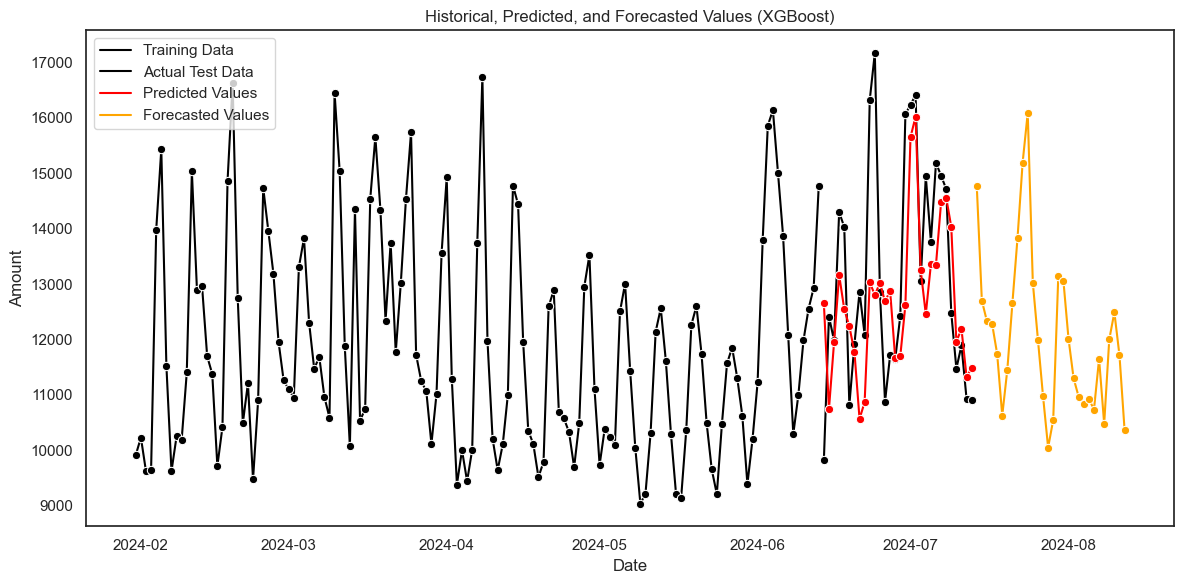

In [244]:
# Plot future forecasts along with historical data

plt.figure(figsize=(12, 6))
sns.set_style('white')

plot_df = pd.DataFrame({
    'Date': np.concatenate([train_data.index, test_data.index]),
    'Amount': np.concatenate([y_train, y_test]),
    'Type': ['Training Data'] * len(y_train) + ['Actual Test Data'] * len(y_test)
})
pred_df = pd.DataFrame({
    'Date': test_data.index,
    'Amount': y_pred,
    'Type': ['Predicted Values'] * len(y_pred)
})
combined_df = pd.concat([plot_df, pred_df])

forecast_df = pd.DataFrame({
    'Date': future_df.index,
    'Amount': future_df['amount'],
    'Type': ['Forecasted Values'] * len(future_df)
})
combined_df = pd.concat([combined_df, forecast_df])

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='Date', y='Amount', hue='Type', palette=['black', 'black', 'red', 'orange'], marker='o')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Historical, Predicted, and Forecasted Values (XGBoost)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

##### Scaled data for NN

In [332]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['amount'].values.reshape(-1, 1))

In [333]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [334]:
time_step = 30  
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## MLP

In [249]:
import tensorflow as tf
from tensorflow import keras

In [335]:
# MLP architecture.

def build_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

# Create and train the model.
mlp_model = build_model((X_train.shape[1],))
history = mlp_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/1000
4/4 [==============================] - 1s 61ms/step - loss: 0.1901 - val_loss: 0.1312
Epoch 2/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.1305 - val_loss: 0.0964
Epoch 3/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0745 - val_loss: 0.1163
Epoch 4/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0866 - val_loss: 0.1023
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.0772 - val_loss: 0.0954
Epoch 6/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.0656 - val_loss: 0.1010
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0690 - val_loss: 0.1051
Epoch 8/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.0644 - val_loss: 0.0988
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.0595 - val_loss: 0.1052
Epoch 10/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0581 - val_loss: 0.0999
Epoch 11/1000

In [336]:
# Evaluate the MLP model.

y_pred = mlp_model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

2/2 [==============================] - 0s 0s/step
Mean Absolute Error (MAE): 1343.0436943655302


In [337]:
# Forecasting for next 30 days

last_values = scaled_data[-time_step:].reshape(1, time_step, 1)
future_predictions = []
for _ in range(30):
    next_pred = mlp_model.predict(last_values)
    future_predictions.append(next_pred[0, 0])
    
    last_values = np.roll(last_values, -1) 
    last_values[0, -1] = next_pred[0, 0]


future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'day': future_dates, 'amount': scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()})
future_df.set_index('day', inplace=True)

1/1 [==============================] - 0s 31ms/step


In [338]:
future_df

,amount
day,
2024-07-14,14563.691406
2024-07-15,14861.980469
2024-07-16,12271.302734
2024-07-17,10818.600586
2024-07-18,11560.375000
2024-07-19,11681.515625
2024-07-20,11543.280273
2024-07-21,13689.002930
2024-07-22,15392.955078


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

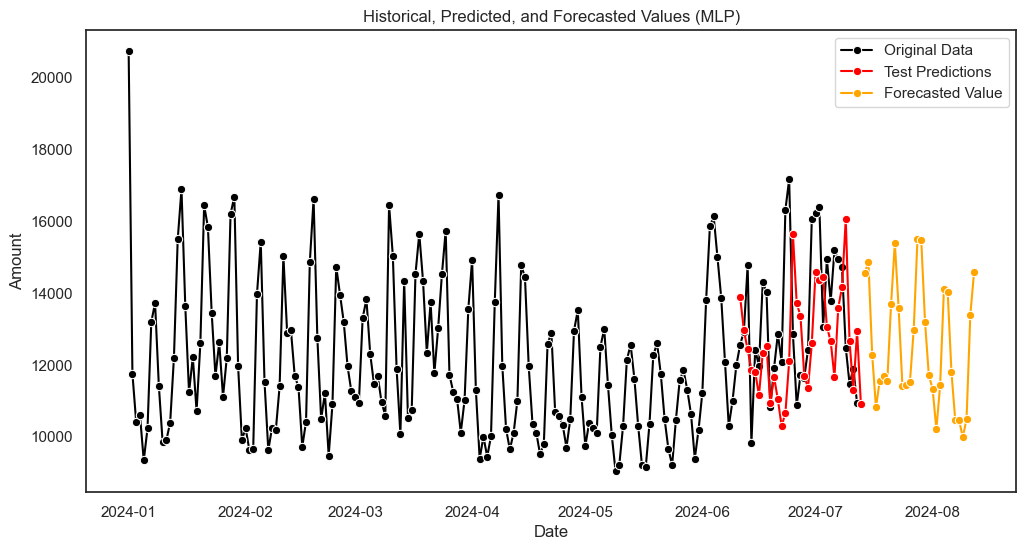

In [358]:
# Plot future forecasts along with historical data

plt.figure(figsize=(12, 6))

sns.lineplot(x=data.index, y=data['amount'], label='Original Data', color='black', marker='o')

test_index = data.index[train_size + time_step + 1:]
sns.lineplot(x=test_index, y=y_pred_inverse.reshape(-1), label='Test Predictions', color='red', marker='o')

sns.lineplot(x=future_df.index, y=future_df["amount"].values, label='Forecasted Value', color='orange', marker='o')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Historical, Predicted, and Forecasted Values (MLP)')
plt.legend()
plt.show()

## LSTM

In [159]:

from tensorflow import keras
from tensorflow.keras import layers

In [359]:
# Create lsstm model and train.

lstm_model = keras.Sequential()
lstm_model.add(layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(layers.LSTM(50, return_sequences=False))
lstm_model.add(layers.Dense(25))
lstm_model.add(layers.Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

history = lstm_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
4/4 [==============================] - 5s 278ms/step - loss: 0.0825 - val_loss: 0.0319
Epoch 2/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0289 - val_loss: 0.0298
Epoch 3/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0339 - val_loss: 0.0267
Epoch 4/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0268 - val_loss: 0.0288
Epoch 5/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0302 - val_loss: 0.0298
Epoch 6/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.0293 - val_loss: 0.0269
Epoch 7/1000
4/4 [==============================] - 0s 79ms/step - loss: 0.0283 - val_loss: 0.0271
Epoch 8/1000
4/4 [==============================] - 0s 96ms/step - loss: 0.0285 - val_loss: 0.0271
Epoch 9/1000
4/4 [==============================] - 0s 95ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 10/1000
4/4 [==============================] - 0s 83ms/step - loss: 0.0273 - val_loss: 0.0275
Epoch 11

In [361]:
# Evaluate the MLP model.

y_pred = lstm_model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

2/2 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 2007.2972005208333


In [362]:
# Forecasting for next 30 days

last_values = scaled_data[-time_step:].reshape(1, time_step, 1)
future_predictions = []
for _ in range(30):
    next_pred = lstm_model.predict(last_values)
    future_predictions.append(next_pred[0, 0])
    
    last_values = np.roll(last_values, -1) 
    last_values[0, -1] = next_pred[0, 0]


future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'day': future_dates, 'amount': scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()})
future_df.set_index('day', inplace=True)

1/1 [==============================] - 0s 12ms/step


In [363]:
future_df

,amount
day,
2024-07-14,12075.663086
2024-07-15,12986.462891
2024-07-16,11645.149414
2024-07-17,9991.264648
2024-07-18,9749.977539
2024-07-19,9552.458008
2024-07-20,11347.250000
2024-07-21,13776.940430
2024-07-22,14071.674805


c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

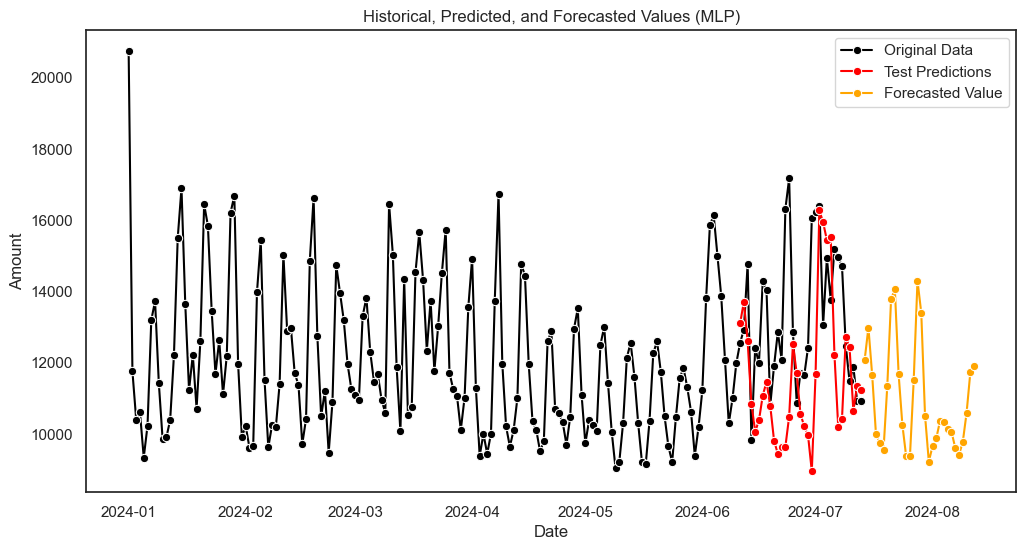

In [364]:
# Plot future forecasts along with historical data

plt.figure(figsize=(12, 6))

sns.lineplot(x=data.index, y=data['amount'], label='Original Data', color='black', marker='o')

test_index = data.index[train_size + time_step + 1:]
sns.lineplot(x=test_index, y=y_pred_inverse.reshape(-1), label='Test Predictions', color='red', marker='o')

sns.lineplot(x=future_df.index, y=future_df["amount"].values, label='Forecasted Value', color='orange', marker='o')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Historical, Predicted, and Forecasted Values (MLP)')
plt.legend()
plt.show()

### !! Since XGB model has smallest mse, we can use it to forecasting...